In [1]:
# # import pca
# from sklearn.decomposition import PCA
# cat_cols = ['col1', 'col2', 'col3']
# # do pca on each cat_cols (_0 to _2047 is the name format of the columns, pca to 50 components)
# for col in cat_cols:
#     pca = PCA(n_components=50, random_state=42)
#     col_to_select = [col + '_' + str(i) for i in range(2048)]
#     pca.fit(X_train[col_to_select])
#     train_pca = pca.transform(X_train[col_to_select])

#     # add the pca components to the train dataframe
#     for i in range(50):
#         X_train[col + '_pca_' + str(i)] = train_pca[:, i]

#     # delete the original columns
#     X_train.drop(col_to_select, axis=1, inplace=True)
#     print(col, 'done')


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
import time
plt.style.use('seaborn-whitegrid')
import warnings
warnings.simplefilter("ignore")
colors = [x['color'] for x in plt.rcParams['axes.prop_cycle']]

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from datetime import date
import lightgbm as lgb

C:\Users\amint\AppData\Local\Temp\ipykernel_15828\2275341947.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [2]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

## Vehicle Loan

In [3]:
df_train= reduce_mem_usage(pd.read_csv('fraud-dataset-benchmark/tmp/train.csv', index_col='UNIQUEID', ))
df_train.DATE_OF_BIRTH = pd.to_datetime(df_train.DATE_OF_BIRTH, format = '%d-%m-%Y')
df_train.DISBURSAL_DATE = pd.to_datetime(df_train.DISBURSAL_DATE, format = '%d-%m-%Y')
import calendar
# Column year
df_train["yearh_OF_BIRTH"] = df_train.DATE_OF_BIRTH.apply(lambda x: x.year)
# Column month
df_train["month_OF_BIRTH"] = df_train.DATE_OF_BIRTH.apply(lambda x: calendar.month_name[x.month])
# Column week
df_train["weekday_OF_BIRTH"] = df_train.DATE_OF_BIRTH.apply(lambda x: calendar.day_name[x.weekday()])

# Column year
df_train["yearh_OF_DISBURSAL"] = df_train.DISBURSAL_DATE.apply(lambda x: x.year)
# Column month
df_train["month_OF_DISBURSAL"] = df_train.DISBURSAL_DATE.apply(lambda x: calendar.month_name[x.month])
# Column week
df_train["weekday_OF_DISBURSAL"] = df_train.DISBURSAL_DATE.apply(lambda x: calendar.day_name[x.weekday()])

# drop date columns
df_train.drop(['DATE_OF_BIRTH', 'DISBURSAL_DATE'], axis=1, inplace=True)

# Changing AVERAGE_ACCT_AGE & CREDIT_HISTORY_LENGTH

df_train[['AVERAGE_ACCT_Yr','AVERAGE_ACCT_Month']] = df_train['AVERAGE_ACCT_AGE'].str.split("yrs",expand=True)
df_train[['AVERAGE_ACCT_Month','AVERAGE_ACCT_Month1']] = df_train['AVERAGE_ACCT_Month'].str.split("mon",expand=True)
df_train["AVERAGE_ACCT_AGE"]= df_train["AVERAGE_ACCT_Yr"].astype(str).astype(int)+((df_train["AVERAGE_ACCT_Month"].astype(str).astype(int))/12)
df_train= df_train.drop(columns= ["AVERAGE_ACCT_Yr","AVERAGE_ACCT_Month",'AVERAGE_ACCT_Month1'])

df_train[['CREDIT_HISTORY_LENGTH_Yr','CREDIT_HISTORY_LENGTH_Month']] = df_train['CREDIT_HISTORY_LENGTH'].str.split("yrs",expand=True)
df_train[['CREDIT_HISTORY_LENGTH_Month','CREDIT_HISTORY_LENGTH_Month1']] = df_train['CREDIT_HISTORY_LENGTH_Month'].str.split("mon",expand=True)
df_train["CREDIT_HISTORY_LENGTH"]= df_train["CREDIT_HISTORY_LENGTH_Yr"].astype(str).astype(int)+((df_train["CREDIT_HISTORY_LENGTH_Month"].astype(str).astype(int))/12)
df_train= df_train.drop(columns= ["CREDIT_HISTORY_LENGTH_Yr","CREDIT_HISTORY_LENGTH_Month",'CREDIT_HISTORY_LENGTH_Month1'])


Memory usage of dataframe is 72.93 MB
Memory usage after optimization is: 20.65 MB
Decreased by 71.7%


In [4]:
cat_cols = ['EMPLOYMENT_TYPE', 'PERFORM_CNS_SCORE_DESCRIPTION', 'month_OF_BIRTH', 'weekday_OF_BIRTH', 'month_OF_DISBURSAL', 'weekday_OF_DISBURSAL']

y_train = df_train['LOAN_DEFAULT']
X_train = df_train.drop('LOAN_DEFAULT', axis=1)


### Small features


In [5]:
X_train = X_train[['DISBURSED_AMOUNT', 'ASSET_COST',] + cat_cols]



In [6]:
X_train

,DISBURSED_AMOUNT,ASSET_COST,EMPLOYMENT_TYPE,PERFORM_CNS_SCORE_DESCRIPTION,month_OF_BIRTH,weekday_OF_BIRTH,month_OF_DISBURSAL,weekday_OF_DISBURSAL
UNIQUEID,,,,,,,,
420825,50578,58400,Salaried,No Bureau History Available,January,Sunday,August,Friday
537409,47145,65550,Self employed,I-Medium Risk,July,Wednesday,September,Wednesday
417566,53278,61360,Self employed,No Bureau History Available,August,Saturday,August,Wednesday
624493,57513,66113,Self employed,L-Very High Risk,December,Thursday,October,Friday
539055,52378,60300,Self employed,No Bureau History Available,December,Friday,September,Wednesday
...,...,...,...,...,...,...,...,...
626432,63213,105405,Salaried,D-Very Low Risk,August,Monday,October,Friday
606141,73651,100600,Self employed,A-Very Low Risk,December,Monday,October,Tuesday
613658,33484,71212,Salaried,No Bureau History Available,June,Tuesday,October,Wednesday


cat = EMPLOYMENT_TYPE, PERFORM_CNS_SCORE_DESCRIPTION

## Fraud Ecomm

In [3]:
df_train= reduce_mem_usage(pd.read_csv('fraud-dataset-benchmark/tmp/Fraud_Data.csv', index_col='user_id', ))

print(f'Shape of train data: {df_train.shape}')

df_ip_country = pd.read_csv('fraud-dataset-benchmark/tmp/IpAddress_to_Country.csv')
print(f'Shape of ip-country data: {df_ip_country.shape}')


df_ip_country.upper_bound_ip_address.astype("float")
df_ip_country.lower_bound_ip_address.astype("float")
df_train.ip_address.astype("float")

# function that takes an IP address as argument and returns country associated based on df_ip_country

def IP_to_country(ip, df_ip_country):
    condition = (df_ip_country['lower_bound_ip_address'] < ip) & (df_ip_country['upper_bound_ip_address'] > ip)
    country = df_ip_country.loc[condition, 'country']
    return country.iloc[0] if not country.empty else "Unknown"    
    
# To affect a country to each IP :
df_train["IP_country"] = df_train["ip_address"].apply(lambda x: IP_to_country(x, df_ip_country))

df_train.signup_time = pd.to_datetime(df_train.signup_time, format = '%Y-%m-%d %H:%M:%S')
df_train.purchase_time = pd.to_datetime(df_train.purchase_time, format = '%Y-%m-%d %H:%M:%S')
import calendar
# Column month
df_train["month_purchase"] = df_train.purchase_time.apply(lambda x: calendar.month_name[x.month])

# --- 3 ---
# Column week
df_train["weekday_purchase"] = df_train.purchase_time.apply(lambda x: calendar.day_name[x.weekday()])

# --- 4 ---
# Column hour_of_the_day
df_train["hour_of_the_day"] = df_train.purchase_time.apply(lambda x: x.hour)

# --- 5 ---
# Column seconds_since_signup
df_train["seconds_since_signup"]= (df_train.purchase_time - df_train.signup_time).apply(lambda x : x.total_seconds())

df_train = df_train.drop(['signup_time', 'purchase_time', 'ip_address', 'device_id'], axis=1)
df_train.head()

df_train['sex'] = df_train['sex'].replace({'M': 'Male', 'F': 'Female'})

cat_cols = ['source', 'browser', 'sex', 'IP_country', 'month_purchase', 'weekday_purchase']

y_train = df_train['class'].copy()

# Drop target, fill in NaNs 
X_train = df_train.drop('class', axis=1)

Memory usage of dataframe is 12.68 MB
Memory usage after optimization is: 19.92 MB
Decreased by -57.0%
Shape of train data: (151112, 10)
Shape of ip-country data: (138846, 3)


### Small feature

In [4]:
X_train.dtypes
# drop age, hours_of_day, seconds_since_signup
X_train.drop(['age', 'hour_of_the_day', 'seconds_since_signup'], axis=1, inplace=True)

## IEEE CIS

In [4]:
df_train_transaction = reduce_mem_usage(pd.read_csv('fraud-dataset-benchmark/tmp/train_transaction.csv', index_col='TransactionID', nrows=10000))
df_train_identity = reduce_mem_usage(pd.read_csv('fraud-dataset-benchmark/tmp/train_identity.csv', index_col='TransactionID'))

print(f'Shape of transaction train data: {df_train_transaction.shape}')
print(f'Shape of identity train data: {df_train_identity.shape}')

df_test_identity = reduce_mem_usage(pd.read_csv('fraud-dataset-benchmark/tmp/test_identity.csv', index_col='TransactionID',))
df_test_transaction = reduce_mem_usage(pd.read_csv('fraud-dataset-benchmark/tmp/test_transaction.csv', index_col='TransactionID',nrows=10000))


# # some columns (id) are wrongly labeled in test_identity. We will correct it
id_cols = [col for col in df_test_identity.columns if col[0]+col[1] == 'id']
rename_cols = {i:'id_'+str(i[-2]+i[-1]) for i in id_cols}
df_test_identity = df_test_identity.rename(columns=rename_cols)


print(f'Shape of transaction train data: {df_test_transaction.shape}')
print(f'Shape of identity train data: {df_test_identity.shape}')

# #combining frames

df_train = df_train_transaction.merge(df_train_identity,on=['TransactionID'],how='left')

# # some columns (id) are wrongly labeled in test_identity. We will correct it
id_cols = [col for col in df_test_identity.columns if col[0]+col[1] == 'id']
rename_cols = {i:'id_'+str(i[-2]+i[-1]) for i in id_cols}
df_test_identity = df_test_identity.rename(columns=rename_cols)
df_test = df_test_transaction.merge(df_test_identity,on=['TransactionID'],how='left')

# Assuming df_train is your DataFrame
missing_percentage = (df_train.isnull().sum() / len(df_train)) * 100
missing_percentage = missing_percentage.sort_values(ascending=False)

# Display missing percentage in descending order
missing_percentage.head(18)

Memory usage of dataframe is 30.06 MB
Memory usage after optimization is: 7.47 MB
Decreased by 75.1%
Memory usage of dataframe is 45.12 MB
Memory usage after optimization is: 10.55 MB
Decreased by 76.6%
Shape of transaction train data: (10000, 393)
Shape of identity train data: (144233, 40)
Memory usage of dataframe is 44.39 MB
Memory usage after optimization is: 10.39 MB
Decreased by 76.6%
Memory usage of dataframe is 29.98 MB
Memory usage after optimization is: 7.46 MB
Decreased by 75.1%
Shape of transaction train data: (10000, 392)
Shape of identity train data: (141907, 40)


id_24    99.46
id_26    99.40
id_21    99.40
id_22    99.40
id_23    99.40
id_08    99.40
id_25    99.40
id_07    99.40
id_27    99.40
D7       97.77
D13      97.20
dist2    96.22
D12      95.94
D14      95.50
D6       95.09
id_18    94.37
id_03    90.76
id_04    90.76
dtype: float64

In [5]:
# set the categorical columns to type 'category'

# cat_cols = ['ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9' ,
#             'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']
cat_cols = ['id_30', 'id_31',
'DeviceType', 'DeviceInfo',
'card4', 'card6',
'P_emaildomain', 'R_emaildomain',]
# for cat in X_train.columns().tolist() - cat_cols:

    # X_train[cat] = X_train[cat].fillna(-999)
    # X_test = X_test.fillna(-999)

## X_train & y_train

In [31]:
# lists = X_train.DeviceInfo.cat.categories.tolist()
# for type in lists:
#     for char in [' ', '.', '-', '/', '(', ')', ';', ':', '+', ',']:
#         if char in type:
#             lists[lists.index(type)] = type.replace(char, '_')
#     new=type.split('_')[0]
#     lists[lists.index(type)] = new
# X_train.DeviceInfo.cat.rename_categories(lists, inplace=True)


ValueError: '2PS64 Build/NRD90M' is not in list

In [24]:
# s = 0 
# for i in X_train.DeviceInfo.unique():
#     print(i)
#     if "HUAWEI" in str(i):
#         # print("Samsung")
#         s+=1

# print(s)

nan
SAMSUNG SM-G892A Build/NRD90M
iOS Device
Windows
MacOS
SM-G930V Build/NRD90M
BLADE A602 Build/MRA58K
XT1635-02 Build/NPN26.118-22-2
Z970
SM-N920V Build/NRD90M
Redmi Note 4 Build/MMB29M
Lenovo PB1-750M Build/S100
LT22i Build/6.2.A.1.100
rv:52.0
SM-G950U Build/NRD90M
LG-H872 Build/NRD90U
LG-K500 Build/MMB29M
SM-P550 Build/MMB29M
SM-J700M Build/MMB29K
Trident/7.0
rv:57.0
SAMSUNG SM-G930T Build/NRD90M
Blade V6 Plus Build/MRA58K
BLL-L23 Build/HUAWEIBLL-L23
KYOCERA-C6742A Build/LMY47V
F3113 Build/33.2.A.4.70
D5306 Build/19.4.A.0.182
M4 SS4457 Build/MRA58K
SM-G955U Build/NRD90M
SM-G610M Build/MMB29K
SAMSUNG SM-G935F Build/NRD90M
XT1635-01
rv:56.0
VS500
CAM-L03 Build/HUAWEICAM-L03
RCT6303W87M7 Build/MRA58K
M4 SS4451 Build/LMY47D
KFFOWI Build/LVY48F
Moto E (4) Build/NMA26.42-19
SAMSUNG
E2306 Build/26.3.A.1.33
Ilium L910 Build/MRA58K
GT-I9300
LG-H420 Build/LRX21Y
Windows NT 6.2
XT1032 Build/LPBS23.13-56-2
GT-I9060M Build/KTU84P
rv:38.0
Moto G (4) Build/NPJS25.93-14-10
SM-G530T
LGMP260 Build/

In [8]:
y_train = df_train['isFraud'].copy()

# Drop target, fill in NaNs 
X_train = df_train.drop('isFraud', axis=1)
# X_test = df_test.copy()

# del df_train, df_test

## Without categorical

In [9]:
X_train

,purchase_value,age,hour_of_the_day,seconds_since_signup
user_id,,,,
22058,34,39,2,4506682.0
333320,16,53,1,17944.0
1359,15,53,18,1.0
150084,44,41,13,492085.0
221365,39,45,18,4361461.0
...,...,...,...,...
345170,43,28,0,5261233.0
274471,35,32,12,931270.0
368416,40,26,7,6681616.0


In [5]:
# cat_cols = ["EMPLOYMENT_TYPE", "PERFORM_CNS_SCORE_DESCRIPTION"]  # replace with the actual column names
# cat_cols = ["month_OF_BIRTH", "weekday_OF_BIRTH", "month_OF_DISBURSAL", "weekday_OF_DISBURSAL"]
X_train = X_train.drop(cat_cols, axis=1)


## Tiny LLAMA

In [7]:
import torch
from transformers import LlamaTokenizer, LlamaForCausalLM, pipeline
model_base_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
model = LlamaForCausalLM.from_pretrained(model_base_name)
tokenizer = LlamaTokenizer.from_pretrained(model_base_name)
feature_extraction = pipeline('feature-extraction', model=model, tokenizer=tokenizer)


In [8]:
# cat_cols_w2v = ['id_30','id_31','DeviceType', 'DeviceInfo','card4', 'card6','P_emaildomain', 'R_emaildomain',]
cat_cols_w2v = cat_cols

In [9]:
import tqdm
import re
id = X_train.index
for col in cat_cols_w2v:
    print(f'Column: {col}')
    # get the unique values (words) in the column
    unique_vals = X_train[col].unique()
    # create a vector of zeros
    vec_temp = np.zeros((len(X_train), 2048), dtype=np.float16)
    n_not_found = 0
    n_space_words = 0
    # iterate over the unique words
    for i, word in tqdm.tqdm(enumerate(unique_vals), total=len(unique_vals)):
        # get the vector of that word
        word = str(word)
        vec = np.zeros((2048))
        n_space_words += 1
        sentences = [word]
        embeddings = feature_extraction(sentences)
        vec = np.average((model(torch.IntTensor([tokenizer(sentences)['input_ids'][0]]),
                                 return_dict=True,
                                 output_hidden_states=True
                                )['hidden_states'])[-1].detach().numpy(),
                          axis=1).reshape((2048)).astype(np.float16)
        # add the vector to the matrix
        vec_temp[X_train[col] == word] = vec
    print(f'Number of words not found: {n_not_found}')
    print(f'Number of words with spaces: {n_space_words}', end='\n\n')
    # create column names for the 200 columns
    col_names = [col + '_' + str(i) for i in range(2048)]
    # create a dataframe with the vector values
    temp_df = pd.DataFrame(vec_temp, columns=col_names, index=id, dtype=np.float16)
    # concatenate the two dataframes using 
    # X_train = pd.concat([X_train, temp_df], axis=1)
    X_train = X_train.join(temp_df, on='UNIQUEID')
    # drop the original column
    X_train = X_train.drop(col, axis=1)
    # ###############################################################################################################
    # # do the same for test set
    # # create a vector of zeros
    # vec_temp = np.zeros((len(X_test), 2048))
    # # iterate over the unique words
    # for i, word in enumerate(unique_vals):
    #     # get the vector of that word
    #     word = str(word)
    #     vec = np.zeros((2048))
    #     n_space_words += 1
    #     sentences = [word]
    #     embeddings = feature_extraction(sentences)
    #     vec = np.average((model(torch.IntTensor([tokenizer(sentences)['input_ids'][0]]),
    #                              return_dict=True,
    #                              output_hidden_states=True
    #                             )['hidden_states'])[-1].detach().numpy(),
    #                       axis=1).reshape((2048))
    #     # add the vector to the matrix
    #     vec_temp[X_test[col] == word] = vec
    # # create column names for the 200 columns
    # col_names = [col + '_' + str(i) for i in range(2048)]
    # # create a dataframe with the vector values
    # temp_df = pd.DataFrame(vec_temp, columns=col_names)
    # # concatenate the dataframe to the train dataframe
    # X_test = pd.concat([X_test, temp_df], axis=1, )
    # # drop the original column
    # X_test = X_test.drop(col, axis=1)

Column: EMPLOYMENT_TYPE


100%|██████████| 3/3 [00:02<00:00,  1.20it/s]


Number of words not found: 0
Number of words with spaces: 3

Column: PERFORM_CNS_SCORE_DESCRIPTION


100%|██████████| 20/20 [00:22<00:00,  1.14s/it]


Number of words not found: 0
Number of words with spaces: 20

Column: month_OF_BIRTH


100%|██████████| 12/12 [00:06<00:00,  1.96it/s]


Number of words not found: 0
Number of words with spaces: 12

Column: weekday_OF_BIRTH


100%|██████████| 7/7 [00:04<00:00,  1.43it/s]


Number of words not found: 0
Number of words with spaces: 7

Column: month_OF_DISBURSAL


100%|██████████| 3/3 [00:02<00:00,  1.16it/s]


Number of words not found: 0
Number of words with spaces: 3

Column: weekday_OF_DISBURSAL


100%|██████████| 7/7 [00:06<00:00,  1.03it/s]


Number of words not found: 0
Number of words with spaces: 7



In [10]:
import gc 
gc.collect()

56

In [11]:
X_train

,DISBURSED_AMOUNT,ASSET_COST,EMPLOYMENT_TYPE_0,EMPLOYMENT_TYPE_1,EMPLOYMENT_TYPE_2,EMPLOYMENT_TYPE_3,EMPLOYMENT_TYPE_4,EMPLOYMENT_TYPE_5,EMPLOYMENT_TYPE_6,EMPLOYMENT_TYPE_7,...,weekday_OF_DISBURSAL_2038,weekday_OF_DISBURSAL_2039,weekday_OF_DISBURSAL_2040,weekday_OF_DISBURSAL_2041,weekday_OF_DISBURSAL_2042,weekday_OF_DISBURSAL_2043,weekday_OF_DISBURSAL_2044,weekday_OF_DISBURSAL_2045,weekday_OF_DISBURSAL_2046,weekday_OF_DISBURSAL_2047
UNIQUEID,,,,,,,,,,,,,,,,,,,,,
420825,50578,58400,0.027924,0.425049,0.435791,-0.745117,-0.084900,-0.424316,0.260498,-1.291992,...,-2.923828,1.741211,-1.594727,2.578125,1.709961,0.000121,0.851074,-3.591797,0.844727,-0.154785
537409,47145,65550,0.172607,1.682617,0.390625,-1.198242,0.600098,0.223145,-1.205078,-0.734375,...,-2.064453,1.550781,-1.554688,1.311523,1.231445,-0.685547,0.688965,-3.199219,1.339844,-0.312500
417566,53278,61360,0.172607,1.682617,0.390625,-1.198242,0.600098,0.223145,-1.205078,-0.734375,...,-2.064453,1.550781,-1.554688,1.311523,1.231445,-0.685547,0.688965,-3.199219,1.339844,-0.312500
624493,57513,66113,0.172607,1.682617,0.390625,-1.198242,0.600098,0.223145,-1.205078,-0.734375,...,-2.923828,1.741211,-1.594727,2.578125,1.709961,0.000121,0.851074,-3.591797,0.844727,-0.154785
539055,52378,60300,0.172607,1.682617,0.390625,-1.198242,0.600098,0.223145,-1.205078,-0.734375,...,-2.064453,1.550781,-1.554688,1.311523,1.231445,-0.685547,0.688965,-3.199219,1.339844,-0.312500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
626432,63213,105405,0.027924,0.425049,0.435791,-0.745117,-0.084900,-0.424316,0.260498,-1.291992,...,-2.923828,1.741211,-1.594727,2.578125,1.709961,0.000121,0.851074,-3.591797,0.844727,-0.154785
606141,73651,100600,0.172607,1.682617,0.390625,-1.198242,0.600098,0.223145,-1.205078,-0.734375,...,-1.960938,1.378906,-1.300781,1.135742,0.921387,-1.192383,1.253906,-1.820312,0.378662,-0.204956
613658,33484,71212,0.027924,0.425049,0.435791,-0.745117,-0.084900,-0.424316,0.260498,-1.291992,...,-2.064453,1.550781,-1.554688,1.311523,1.231445,-0.685547,0.688965,-3.199219,1.339844,-0.312500


In [12]:
# X_train_backup = X_train.copy()

In [13]:
# import pca
from sklearn.decomposition import PCA
# cat_cols = ['col1', 'col2', 'col3']
# do pca on each cat_cols (_0 to _2047 is the name format of the columns, pca to 50 components)
for col in cat_cols:
    pca = PCA(n_components=200, random_state=42)
    col_to_select = [col + '_' + str(i) for i in range(2048)]
    pca.fit(X_train[col_to_select])
    train_pca = pca.transform(X_train[col_to_select])

    # add the pca components to the train dataframe
    for i in range(200):
        X_train[col + '_pca_' + str(i)] = train_pca[:, i]

    # delete the original columns
    X_train.drop(col_to_select, axis=1, inplace=True)
    print(col, 'done')


EMPLOYMENT_TYPE done
PERFORM_CNS_SCORE_DESCRIPTION done
month_OF_BIRTH done
weekday_OF_BIRTH done
month_OF_DISBURSAL done
weekday_OF_DISBURSAL done


### Feature reduction

In [63]:
num_features_to_keep

16

In [31]:
# Read the feature importance from the "fraducecom" LGBM model
feature_importance = pd.read_csv('plots/vehicle_lgbm_LLAMA-PCA200_feature_importance.csv')

# Sort the feature importance in descending order
feature_importance = feature_importance.sort_values(by='importance', ascending=False)

# Calculate the number of features to keep (top 30 percent)
num_features_to_keep = int(len(feature_importance) * 0.20)

# Select the top 20 percent of features to keep
top_features = feature_importance.head(num_features_to_keep)['feature'].tolist()


In [32]:
X_train = X_train_backup.copy()
# X_train_backup = X_train.copy()

In [34]:

# # remove these from top features 
for e in ['CURRENT_PINCODE_ID', 'LTV', 'SUPPLIER_ID', 'EMPLOYEE_CODE_ID', 'yearh_OF_BIRTH', 'BRANCH_ID', 'CREDIT_HISTORY_LENGTH', 'PRIMARY_INSTAL_AMT', 'PRI_CURRENT_BALANCE', 'AVERAGE_ACCT_AGE', 'STATE_ID', 'PRI_SANCTIONED_AMOUNT', 'PRI_NO_OF_ACCTS', 'MANUFACTURER_ID', 'PRI_DISBURSED_AMOUNT', 'PERFORM_CNS_SCORE', 'NO_OF_INQUIRIES', 'PRI_OVERDUE_ACCTS', 'PRI_ACTIVE_ACCTS', 'DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS', 'NEW_ACCTS_IN_LAST_SIX_MONTHS', 'VOTERID_FLAG', 'AADHAR_FLAG', 'PAN_FLAG', 'SEC_CURRENT_BALANCE', 'SEC_SANCTIONED_AMOUNT', 'SEC_INSTAL_AMT', 'SEC_DISBURSED_AMOUNT', 'SEC_NO_OF_ACCTS']:
    top_features.remove(e)

# Keep only the selected features in the X_train dataframe
X_train = X_train[top_features]



## Adding Edgar W2V


In [146]:
from gensim.models.keyedvectors import KeyedVectors

model = KeyedVectors.load_word2vec_format('edgar-w2v/edgar.word.w2v.200.bin', binary=True)
model.save_word2vec_format('edgar-w2v/edgar.word.w2v.200.vocab', binary=False)


In [147]:

word_list = ['discover',]
vectors = [model.get_vector(word) for word in word_list]
print((vectors[0].shape))


(200,)


In [148]:
similar_words = model.most_similar('mastercard')


In [149]:
similar_words

[('visa', 0.9166603684425354),
 ('paypal', 0.727387011051178),
 ('card', 0.7263432741165161),
 ('debit', 0.7225877046585083),
 ('bankcard', 0.6708196997642517),
 ('interac', 0.6536964178085327),
 ('cardholders', 0.6438126564025879),
 ('diners', 0.6250543594360352),
 ('cards', 0.6202710270881653),
 ('europay', 0.6150788068771362)]

In [150]:
X_train

,DISBURSED_AMOUNT,ASSET_COST,EMPLOYMENT_TYPE,PERFORM_CNS_SCORE_DESCRIPTION,month_OF_BIRTH,weekday_OF_BIRTH,month_OF_DISBURSAL,weekday_OF_DISBURSAL
UNIQUEID,,,,,,,,
420825,50578,58400,Salaried,No Bureau History Available,January,Sunday,August,Friday
537409,47145,65550,Self employed,I-Medium Risk,July,Wednesday,September,Wednesday
417566,53278,61360,Self employed,No Bureau History Available,August,Saturday,August,Wednesday
624493,57513,66113,Self employed,L-Very High Risk,December,Thursday,October,Friday
539055,52378,60300,Self employed,No Bureau History Available,December,Friday,September,Wednesday
...,...,...,...,...,...,...,...,...
626432,63213,105405,Salaried,D-Very Low Risk,August,Monday,October,Friday
606141,73651,100600,Self employed,A-Very Low Risk,December,Monday,October,Tuesday
613658,33484,71212,Salaried,No Bureau History Available,June,Tuesday,October,Wednesday


In [158]:
# For every word in a categorical column, use the model.get_vector to get the vector of that word and then replace it. The vectors shape are 200, so for each categorical column, we should add 200 columns for the vector. 
# Iterate over categorical columns
# cat_cols_w2v = ['id_30', 'id_31',
# 'DeviceType', 'DeviceInfo',
# 'card4', 'card6',
# 'P_emaildomain', 'R_emaildomain',]
# for e in ['ProductCD','card1', 'card2', 'card3', 'card5', 'addr1', 'addr2', 'dist1' 'dist2', ]:
#     cat_cols.remove(e)
# cat_cols_w2v = cat_cols
# cat_cols = ["EMPLOYMENT_TYPE", "PERFORM_CNS_SCORE_DESCRIPTION", "month_OF_BIRTH", "weekday_OF_BIRTH", "month_OF_DISBURSAL", "weekday_OF_DISBURSAL"]

In [151]:
import re
id = X_train.index
for col in cat_cols:
    # Create new columns for vector components
    # get the unique values (words) in the column
    unique_vals = X_train[col].unique()
    # create a vector of zeros
    vec_temp = np.zeros((len(X_train), 200))
    n_not_found = 0
    n_space_words = 0
    # iterate over the unique words
    for i, word in enumerate(unique_vals):
        # get the vector of that word
        word = str(word)
        # remove special characters
        word = re.sub(r'[^a-zA-Z0-9\s]', ' ', word)
        if ' ' in word or word is not 'nan':
            vec_t = np.zeros((200))
            n_space_words += 1
            for w in word.split(' '):
                # small case
                w = w.lower()
                try:
                    vec_t += model.get_vector(w)
                except KeyError:
                    continue
                    n_not_found += 1
            vec = vec_t/len(word.split(' '))
        else:
            vec = model.get_vector(word)
        # add the vector to the matrix
        vec_temp[X_train[col] == word] = vec
    print(f'Column: {col}')
    print(f'Number of words not found: {n_not_found}')
    print(f'Number of words with spaces: {n_space_words}', end='\n\n')
    # create column names for the 200 columns
    col_names = [col + '_' + str(i) for i in range(200)]
    # create a dataframe with the vector values
    temp_df = pd.DataFrame(vec_temp, columns=col_names, index=id)
    # concatenate the two dataframes using 
    X_train = pd.concat([X_train, temp_df], axis=1)
    # drop the original column
    X_train = X_train.drop(col, axis=1)
    ###############################################################################################################
    # # do the same for test set
    # # create a vector of zeros
    # vec_temp = np.zeros((len(X_test), 200))
    # # iterate over the unique words
    # for i, word in enumerate(unique_vals):
    #     # get the vector of that word
    #     word = str(word)
    #     # remove special characters
    #     word = re.sub(r'[^a-zA-Z0-9\s]', ' ', word)
    #     if ' ' in word or word is not 'nan':
    #         vec_t = np.zeros((200))
    #         for w in word.split(' '):
    #             # small case
    #             w = w.lower()
    #             try:
    #                 vec_t += model.get_vector(w)
    #             except KeyError:
    #                 continue
    #         vec = vec_t/len(word.split(' '))
    #     else:
    #         vec = model.get_vector(word)
    #     # add the vector to the matrix
    #     vec_temp[X_test[col] == word] = vec
    # # create column names for the 200 columns
    # col_names = [col + '_' + str(i) for i in range(200)]
    # # create a dataframe with the vector values
    # temp_df = pd.DataFrame(vec_temp, columns=col_names)
    # # concatenate the dataframe to the train dataframe
    # X_test = pd.concat([X_test, temp_df], axis=1, )
    # # drop the original column
    # X_test = X_test.drop(col, axis=1)

Column: EMPLOYMENT_TYPE
Number of words not found: 0
Number of words with spaces: 3



Column: PERFORM_CNS_SCORE_DESCRIPTION
Number of words not found: 0
Number of words with spaces: 20

Column: month_OF_BIRTH
Number of words not found: 0
Number of words with spaces: 12

Column: weekday_OF_BIRTH
Number of words not found: 0
Number of words with spaces: 7

Column: month_OF_DISBURSAL
Number of words not found: 0
Number of words with spaces: 3

Column: weekday_OF_DISBURSAL
Number of words not found: 0
Number of words with spaces: 7



### Feature reduction

In [244]:
# X_train_backup = X_train.copy()
X_train = X_train_backup.copy()

In [246]:
# Read the feature importance from the "fraducecom" LGBM model
feature_importance = pd.read_csv('plots/vehicle_lgbm_W2V_feature_importance.csv')

# Sort the feature importance in descending order
feature_importance = feature_importance.sort_values(by='importance', ascending=False)

# Calculate the number of features to keep (top 10 percent)
num_features_to_keep = int(len(feature_importance) * 0.60)

# Select the top 20 percent of features to keep
top_features = feature_importance.head(num_features_to_keep)['feature'].tolist()

# remove a list of features from the top_features
for e in ['CURRENT_PINCODE_ID', 'EMPLOYEE_CODE_ID', 'LTV', 'SUPPLIER_ID', 'yearh_OF_BIRTH', 'BRANCH_ID', 'PERFORM_CNS_SCORE', 'PRIMARY_INSTAL_AMT', 'CREDIT_HISTORY_LENGTH', 'AVERAGE_ACCT_AGE', 'PRI_CURRENT_BALANCE', 'PRI_SANCTIONED_AMOUNT', 'STATE_ID', 'PRI_DISBURSED_AMOUNT', 'PRI_NO_OF_ACCTS', 'MANUFACTURER_ID', 'NO_OF_INQUIRIES', 'PRI_OVERDUE_ACCTS', 'PRI_ACTIVE_ACCTS', 'DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS', 'NEW_ACCTS_IN_LAST_SIX_MONTHS', 'VOTERID_FLAG', 'AADHAR_FLAG', 'PAN_FLAG', 'SEC_CURRENT_BALANCE', 'SEC_SANCTIONED_AMOUNT', 'SEC_INSTAL_AMT', 'SEC_DISBURSED_AMOUNT', 'SEC_NO_OF_ACCTS', 'SEC_OVERDUE_ACCTS', 'DRIVING_FLAG', 'SEC_ACTIVE_ACCTS', 'PASSPORT_FLAG']:
    top_features.remove(e)

# Keep only the selected features in the X_train dataframe
X_train = X_train[top_features]

X_train

,DISBURSED_AMOUNT,ASSET_COST,EMPLOYMENT_TYPE_0,month_OF_DISBURSAL_1,month_OF_DISBURSAL_0,weekday_OF_DISBURSAL_0,weekday_OF_DISBURSAL_1,weekday_OF_BIRTH_0,weekday_OF_BIRTH_1,weekday_OF_BIRTH_5,...,EMPLOYMENT_TYPE_173,PERFORM_CNS_SCORE_DESCRIPTION_28,EMPLOYMENT_TYPE_165,EMPLOYMENT_TYPE_166,EMPLOYMENT_TYPE_167,PERFORM_CNS_SCORE_DESCRIPTION_71,PERFORM_CNS_SCORE_DESCRIPTION_73,PERFORM_CNS_SCORE_DESCRIPTION_29,EMPLOYMENT_TYPE_144,EMPLOYMENT_TYPE_146
UNIQUEID,,,,,,,,,,,,,,,,,,,,,
420825,50578,58400,0.186978,-0.001804,-0.176254,0.295099,-0.230588,0.019230,-0.083245,0.117419,...,-0.157357,-0.091159,-0.469762,-0.356561,-0.007394,-0.026568,-0.138759,-0.185782,-0.061423,-0.126277
537409,47145,65550,-0.107222,0.118617,-0.278893,0.332321,0.010851,0.332321,0.010851,0.478146,...,0.102104,0.000000,0.052480,0.017141,0.000835,0.000000,0.000000,0.000000,-0.347554,0.138947
417566,53278,61360,-0.107222,-0.001804,-0.176254,0.332321,0.010851,0.151769,-0.148860,0.590889,...,0.102104,-0.091159,0.052480,0.017141,0.000835,-0.026568,-0.138759,-0.185782,-0.347554,0.138947
624493,57513,66113,-0.107222,-0.011925,-0.205375,0.295099,-0.230588,0.268125,0.001261,0.236754,...,0.102104,0.000000,0.052480,0.017141,0.000835,0.000000,0.000000,0.000000,-0.347554,0.138947
539055,52378,60300,-0.107222,0.118617,-0.278893,0.332321,0.010851,0.295099,-0.230588,0.187261,...,0.102104,-0.091159,0.052480,0.017141,0.000835,-0.026568,-0.138759,-0.185782,-0.347554,0.138947
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
626432,63213,105405,0.186978,-0.011925,-0.205375,0.295099,-0.230588,0.015668,0.066173,0.326115,...,-0.157357,0.000000,-0.469762,-0.356561,-0.007394,0.000000,0.000000,0.000000,-0.061423,-0.126277
606141,73651,100600,-0.107222,-0.011925,-0.205375,0.172288,0.283263,0.015668,0.066173,0.326115,...,0.102104,0.000000,0.052480,0.017141,0.000835,0.000000,0.000000,0.000000,-0.347554,0.138947
613658,33484,71212,0.186978,-0.011925,-0.205375,0.332321,0.010851,0.172288,0.283263,0.277073,...,-0.157357,-0.091159,-0.469762,-0.356561,-0.007394,-0.026568,-0.138759,-0.185782,-0.061423,-0.126277


In [18]:
# How many 0.0 are in the whole dataset?
df_train.isin([0.0]).sum().sum()

9442

In [83]:
X_train.isin([0.0]).sum().sum()

12292320

In [74]:
# Check if categorical columns are categorical
for col in cat_cols:
    if col not in X_train.columns or not pd.api.types.is_categorical_dtype(X_train[col]):
        X_train[col] = X_train[col].astype('category')
        X_test[col] = X_test[col].astype('category')

# Set the categories of categorical columns
for col in cat_cols:
    X_train[col] = X_train[col].cat.set_categories(['idk'] + X_train[col].cat.categories.tolist())
    X_test[col] = X_test[col].cat.set_categories(['idk'] + X_test[col].cat.categories.tolist())


KeyError: 'id_30'

In [8]:

# Fill in NaN values in categorical columns
X_train[cat_cols] = X_train[cat_cols].fillna('idk')
X_test[cat_cols] = X_test[cat_cols].fillna('idk')


lets forget the fillna for a second because it says set cateogrical first error 


In [10]:
# set the categorical columns to type 'category'

# cat_cols = ['ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9' ,
#             'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']
# for cat in X_train.columns().tolist() - cat_cols:

    # X_train[cat] = X_train[cat].fillna(-999)
    # X_test = X_test.fillna(-999)

## LGBM Categorical

In [135]:
# cat_cols = ['ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9' ,
            # 'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']
# cat_cols = ["EMPLOYMENT_TYPE", "PERFORM_CNS_SCORE_DESCRIPTION" ,"month_OF_BIRTH", "weekday_OF_BIRTH", "month_OF_DISBURSAL", "weekday_OF_DISBURSAL"]
def convert_to_lgbm_categorical(data, cat_cols):
    for col in cat_cols:
        data[col] = data[col].astype('category')
    return data

# Apply the function to X_train
X_train = convert_to_lgbm_categorical(X_train, cat_cols)


## One Hot

In [96]:
import re
def one_hot_encoder_one(data,feature,keep_first=True):

    one_hot_cols = pd.get_dummies(data[feature])
    
    for i,col in enumerate(one_hot_cols.columns):
        one_hot_cols.rename({col:f'{feature}_'+str(col)+str(i)},axis=1,inplace=True)
    
    one_hot_cols.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '_-_', x), inplace=True)
    new_data = pd.concat([data,one_hot_cols],axis=1)
    new_data.drop(feature,axis=1,inplace=True)
    
    if keep_first == False:
        new_data=new_data.iloc[:,1:]
    
    return new_data

In [97]:
X_one_hot_train=X_train.copy()
# X_one_hot_test=X_test.copy()
for col in X_one_hot_train.select_dtypes(include=['category', 'object']).columns:
    X_one_hot_train=one_hot_encoder_one(X_one_hot_train,col)

# for col in X_one_hot_test.select_dtypes(include='category').columns:
#     X_one_hot_test=one_hot_encoder_one(X_one_hot_test,col)

In [98]:
X_train = X_one_hot_train.copy()

In [99]:
X_train

,DISBURSED_AMOUNT,ASSET_COST,EMPLOYMENT_TYPE_Salaried0,EMPLOYMENT_TYPE_Self_-_employed1,PERFORM_CNS_SCORE_DESCRIPTION_A_-_Very_-_Low_-_Risk0,PERFORM_CNS_SCORE_DESCRIPTION_B_-_Very_-_Low_-_Risk1,PERFORM_CNS_SCORE_DESCRIPTION_C_-_Very_-_Low_-_Risk2,PERFORM_CNS_SCORE_DESCRIPTION_D_-_Very_-_Low_-_Risk3,PERFORM_CNS_SCORE_DESCRIPTION_E_-_Low_-_Risk4,PERFORM_CNS_SCORE_DESCRIPTION_F_-_Low_-_Risk5,...,month_OF_DISBURSAL_August0,month_OF_DISBURSAL_October1,month_OF_DISBURSAL_September2,weekday_OF_DISBURSAL_Friday0,weekday_OF_DISBURSAL_Monday1,weekday_OF_DISBURSAL_Saturday2,weekday_OF_DISBURSAL_Sunday3,weekday_OF_DISBURSAL_Thursday4,weekday_OF_DISBURSAL_Tuesday5,weekday_OF_DISBURSAL_Wednesday6
UNIQUEID,,,,,,,,,,,,,,,,,,,,,
420825,50578,58400,1,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0
537409,47145,65550,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
417566,53278,61360,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
624493,57513,66113,0,1,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
539055,52378,60300,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
626432,63213,105405,1,0,0,0,0,1,0,0,...,0,1,0,1,0,0,0,0,0,0
606141,73651,100600,0,1,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
613658,33484,71212,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1


## Label Encoding

In [83]:
X_train

,DISBURSED_AMOUNT,ASSET_COST,EMPLOYMENT_TYPE,PERFORM_CNS_SCORE_DESCRIPTION,month_OF_BIRTH,weekday_OF_BIRTH,month_OF_DISBURSAL,weekday_OF_DISBURSAL
UNIQUEID,,,,,,,,
420825,50578,58400,Salaried,No Bureau History Available,January,Sunday,August,Friday
537409,47145,65550,Self employed,I-Medium Risk,July,Wednesday,September,Wednesday
417566,53278,61360,Self employed,No Bureau History Available,August,Saturday,August,Wednesday
624493,57513,66113,Self employed,L-Very High Risk,December,Thursday,October,Friday
539055,52378,60300,Self employed,No Bureau History Available,December,Friday,September,Wednesday
...,...,...,...,...,...,...,...,...
626432,63213,105405,Salaried,D-Very Low Risk,August,Monday,October,Friday
606141,73651,100600,Self employed,A-Very Low Risk,December,Monday,October,Tuesday
613658,33484,71212,Salaried,No Bureau History Available,June,Tuesday,October,Wednesday


In [84]:

for i in X_train.columns:
    print(i , " : " ,X_train[i].dtype)

DISBURSED_AMOUNT  :  int32
ASSET_COST  :  int32
EMPLOYMENT_TYPE  :  category
PERFORM_CNS_SCORE_DESCRIPTION  :  category
month_OF_BIRTH  :  object
weekday_OF_BIRTH  :  object
month_OF_DISBURSAL  :  object
weekday_OF_DISBURSAL  :  object


In [85]:
for f in X_train.columns:
    if X_train[f].dtype=='object' or X_train[f].dtype=='category' :# or X_test[f].dtype=='object':
        lbl = preprocessing.LabelEncoder()
        # lbl.fit(list(X_train[f].values) + list(X_test[f].values))
        lbl.fit(list(X_train[f].values) )
        X_train[f] = lbl.transform(list(X_train[f].values))
        # X_test[f] = lbl.transform(list(X_test[f].values))

## Target encoding


In [123]:
from category_encoders.target_encoder import TargetEncoder

X_one_hot_train=X_train.copy()
for col in X_one_hot_train.select_dtypes(include=['object','category']).columns:
    te=TargetEncoder()
    X_one_hot_train[col]=te.fit_transform(X_one_hot_train[col],y_train)

In [124]:
X_train = X_one_hot_train

## M-Estimate

In [111]:
from category_encoders import MEstimateEncoder
feature_list = list(X_train.columns) # you can custumize later.
MEE_encoder = MEstimateEncoder()
X_train = MEE_encoder.fit_transform(X_train[feature_list], y_train)
# test_mee = MEE_encoder.transform(X_test[feature_list])

In [112]:
X_train

,DISBURSED_AMOUNT,ASSET_COST,EMPLOYMENT_TYPE,PERFORM_CNS_SCORE_DESCRIPTION,month_OF_BIRTH,weekday_OF_BIRTH,month_OF_DISBURSAL,weekday_OF_DISBURSAL
UNIQUEID,,,,,,,,
420825,50578,58400,0.203458,0.231312,0.245389,0.221228,0.215670,0.221441
537409,47145,65550,0.227657,0.272619,0.206409,0.218084,0.191876,0.229070
417566,53278,61360,0.227657,0.231312,0.201355,0.214974,0.215670,0.229070
624493,57513,66113,0.227657,0.280367,0.198584,0.215627,0.235147,0.221441
539055,52378,60300,0.227657,0.231312,0.198584,0.220123,0.191876,0.229070
...,...,...,...,...,...,...,...,...
626432,63213,105405,0.203458,0.149592,0.201355,0.214775,0.235147,0.221441
606141,73651,100600,0.227657,0.165750,0.198584,0.214775,0.235147,0.213406
613658,33484,71212,0.203458,0.231312,0.201236,0.214594,0.235147,0.229070


# Corss val

In [8]:
X_train.memory_usage(deep=True).sum() / 1024**2 # MB

3.8910140991210938

In [15]:
for col in X_train.columns:
    print(X_train[col].dtype)

int16
int8
int64
float64


In [17]:
X_train

,purchase_value,age,hour_of_the_day,seconds_since_signup
user_id,,,,
22058,34,39,2,4506682.0
333320,16,53,1,17944.0
1359,15,53,18,1.0
150084,44,41,13,492085.0
221365,39,45,18,4361461.0
...,...,...,...,...
345170,43,28,0,5261233.0
274471,35,32,12,931270.0
368416,40,26,7,6681616.0


# DNN

In [10]:
import tensorflow as tf

class AveragePrecision(tf.keras.metrics.Metric):
    def __init__(self, name='average_precision', **kwargs):
        super(AveragePrecision, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name='tp', initializer='zeros')
        self.false_positives = self.add_weight(name='fp', initializer='zeros')
        self.total_positives = self.add_weight(name='total_pos', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, tf.bool)
        y_pred = tf.cast(y_pred, tf.bool)

        true_positives = tf.reduce_sum(tf.cast(tf.logical_and(y_true, y_pred), tf.float32))
        false_positives = tf.reduce_sum(tf.cast(tf.logical_and(tf.logical_not(y_true), y_pred), tf.float32))
        total_positives = tf.reduce_sum(tf.cast(y_true, tf.float32))

        self.true_positives.assign_add(true_positives)
        self.false_positives.assign_add(false_positives)
        self.total_positives.assign_add(total_positives)

    def result(self):
        precision = self.true_positives / (self.true_positives + self.false_positives + tf.keras.backend.epsilon())
        recall = self.true_positives / (self.total_positives + tf.keras.backend.epsilon())
        average_precision = tf.reduce_sum(precision * tf.cast(recall, tf.float32)) / tf.reduce_sum(tf.cast(self.total_positives > 0, tf.float32))
        return average_precision

    def reset_states(self):
        self.true_positives.assign(0)
        self.false_positives.assign(0)
        self.total_positives.assign(0)


In [11]:
import gc
gc.collect()

16

In [18]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve, auc, average_precision_score
import shap

input_dim = X_train.shape[1] #########################################################

# Perform stratified cross-validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
# define list to store the results
precision_list = []
recall_list = []
fpr_list = []
tpr_list = []
auc_scores = []
average_precision_scores = []
feature_importance = []



for train_index, val_index in skf.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    # run with cpu 
    with tf.device('/CPU:0'):
        
        # Define the architecture of the DNN
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(64, activation='relu', input_shape=(input_dim,)),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])
        
        # early stopping
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
        
        # Compile the model using custom metric
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[AveragePrecision(), 'AUC'],)

        # Train the model on the current fold with early stopping
        model.fit(X_train_fold, y_train_fold, epochs=10, batch_size=64, validation_data=(X_val_fold, y_val_fold), callbacks=[early_stopping])

        # Evaluate the model on the current fold
        y_val_pred = model.predict(X_val_fold)
        y_scores = model.predict(X_train_fold)
        precision, recall, _ = precision_recall_curve(y_val_fold, y_val_pred)
        fpr, tpr, _ = roc_curve(y_val_fold, y_val_pred)
        average_precision_scores.append(average_precision_score(y_val_fold, y_val_pred))
        auc_scores.append(auc(fpr, tpr))
        precision_list.append(precision)
        recall_list.append(recall)
        fpr_list.append(fpr)
        tpr_list.append(tpr)
    # shap sample for fast running
    # X_train_fold = X_train_fold.sample(frac=0.1)
    # Create an explainer
    # explainer = shap.Explainer(model, X_train_fold)
    # # Get shap values
    # shap_values = explainer(X_train_fold)
    # # Get feature importance
    # feature_importance.append(np.abs(shap_values.values).mean(0))




Epoch 1/10
2125/2125 [==============================] - 3s 1ms/step - loss: 1315.8414 - average_precision: 0.2920 - auc: 0.7551 - val_loss: 332.9382 - val_average_precision: 0.4901 - val_auc: 0.7709
Epoch 2/10
2125/2125 [==============================] - 2s 1ms/step - loss: 435.5298 - average_precision: 0.2827 - auc: 0.7553 - val_loss: 102.2551 - val_average_precision: 0.4110 - val_auc: 0.7713
Epoch 3/10
2125/2125 [==============================] - 2s 1ms/step - loss: 194.2505 - average_precision: 0.2615 - auc: 0.7564 - val_loss: 22.2453 - val_average_precision: 0.2379 - val_auc: 0.7704
Epoch 4/10
2125/2125 [==============================] - 2s 1ms/step - loss: 83.2871 - average_precision: 0.2182 - auc: 0.7561 - val_loss: 2.9634 - val_average_precision: 0.0988 - val_auc: 0.7691
Epoch 5/10
2125/2125 [==============================] - 2s 1ms/step - loss: 34.8794 - average_precision: 0.1749 - auc: 0.7584 - val_loss: 36.6745 - val_average_precision: 0.2958 - val_auc: 0.7708
Epoch 6/10
2125

In [19]:
# print the average AUC score and std deviation
print(f'Average ROC AUC score: {round(np.mean(auc_scores),4)} +/- {round(np.std(auc_scores),4)}')
# print the average precision score and std deviation
print(f'Average precision score: {round(np.mean(average_precision_scores),4)} +/- {round(np.std(average_precision_scores),4)}')



Average ROC AUC score: 0.7677 +/- 0.0046
Average precision score: 0.5804 +/- 0.0264


In [20]:
print("llama 200")

llama 200


In [33]:
X_train = np.array(X_train)

# Reshape the input data if needed
if len(X_train.shape) == 1:
    X_train = X_train.reshape(-1, 1)

explainer = shap.Explainer(model, X_train_fold)
shap_values = explainer(X_train)

# Get feature importance
shap.summary_plot(shap_values, X_train, feature_names=['Feature_'+str(i) for i in range(input_dim)])

AttributeError: Exception encountered when calling layer "sequential_22" (type Sequential).

'tuple' object has no attribute 'rank'

Call arguments received:
  • inputs=       purchase_value   age  hour_of_the_day  seconds_since_signup  \
0                47.0  38.0             10.0             7971446.0   
1                54.0  25.0              3.0            10288209.0   
2                22.0  38.0             23.0             2178129.0   
3                39.0  38.0             19.0               39667.0   
4                57.0  21.0             18.0             4653447.0   
...               ...   ...              ...                   ...   
41095            13.0  35.0             21.0             2763803.0   
41096            29.0  19.0             20.0             9975774.0   
41097            39.0  25.0             19.0             7549462.0   
41098            24.0  31.0             12.0             2686918.0   
41099            40.0  56.0             10.0             2269337.0   

       source_pca_0  source_pca_1  source_pca_2  source_pca_3  source_pca_4  \
0         25.269724     -2.959213 -8.437695e-15  5.440093e-15 -8.659740e-15   
1        -11.155291     31.579611  2.192690e-15  1.221245e-15 -6.938894e-16   
2        -11.155291     31.579611  2.192690e-15  1.221245e-15 -6.938894e-16   
3        -19.329307    -13.027150  2.491063e-15 -4.218847e-15  1.065814e-14   
4         25.269724     -2.959213 -8.437695e-15  5.440093e-15 -8.659740e-15   
...             ...           ...           ...           ...           ...   
41095     25.269724     -2.959213 -8.437695e-15  5.440093e-15 -8.659740e-15   
41096     25.269724     -2.959213 -8.437695e-15  5.440093e-15 -8.659740e-15   
41097     25.269724     -2.959213 -8.437695e-15  5.440093e-15 -8.659740e-15   
41098    -11.155291     31.579611  2.192690e-15  1.221245e-15 -6.938894e-16   
41099    -19.329307    -13.027150  2.491063e-15 -4.218847e-15  1.065814e-14   

       source_pca_5  ...  weekday_purchase_pca_190  weekday_purchase_pca_191  \
0      3.774758e-15  ...             -1.110223e-16             -1.679212e-15   
1      1.731254e-15  ...              1.998401e-15             -9.436896e-16   
2      1.731254e-15  ...             -2.359224e-16              1.694825e-15   
3     -4.107825e-15  ...              1.026956e-15             -1.526557e-15   
4      3.774758e-15  ...             -1.110223e-16             -1.679212e-15   
...             ...  ...                       ...                       ...   
41095  3.774758e-15  ...             -8.326673e-16              5.922996e-16   
41096  3.774758e-15  ...              1.026956e-15             -1.526557e-15   
41097  3.774758e-15  ...             -9.992007e-16              1.076396e-15   
41098  1.731254e-15  ...              1.026956e-15             -1.526557e-15   
41099 -4.107825e-15  ...             -9.992007e-16              1.076396e-15   

       weekday_purchase_pca_192  weekday_purchase_pca_193  \
0                 -6.383782e-16              1.526557e-16   
1                 -1.366962e-15             -2.775558e-17   
2                 -4.996004e-16              0.000000e+00   
3                 -3.330669e-16             -4.163336e-16   
4                 -6.383782e-16              1.526557e-16   
...                         ...                       ...   
41095              4.857226e-16              5.290907e-16   
41096             -3.330669e-16             -4.163336e-16   
41097              1.425943e-15             -1.110223e-16   
41098             -3.330669e-16             -4.163336e-16   
41099              1.425943e-15             -1.110223e-16   

       weekday_purchase_pca_194  weekday_purchase_pca_195  \
0                  7.494005e-16              1.054712e-15   
1                 -6.661338e-16              5.689893e-16   
2                  3.330669e-16             -1.110223e-15   
3                  8.604228e-16              1.831868e-15   
4                  7.494005e-16              1.054712e-15   
...                         ...                       ...   
41095             -4.024558e-16             -5.637851e-16   
41096              8.604228e-16              1.831868e-15   
41097             -9.367507e-16             -3.816392e-16   
41098              8.604228e-16              1.831868e-15   
41099             -9.367507e-16             -3.816392e-16   

       weekday_purchase_pca_196  weekday_purchase_pca_197  \
0                  2.220446e-16              1.391248e-15   
1                  5.551115e-17              1.179612e-15   
2                 -2.740863e-16             -6.609296e-16   
3                  3.885781e-16              5.551115e-16   
4                  2.220446e-16              1.391248e-15   
...                         ...                       ...   
41095             -5.967449e-16             -9.367507e-16   
41096              3.885781e-16              5.551115e-16   
41097              2.775558e-16             -7.771561e-16   
41098              3.885781e-16              5.551115e-16   
41099              2.775558e-16             -7.771561e-16   

       weekday_purchase_pca_198  weekday_purchase_pca_199  
0                 -7.424616e-16             -1.065120e-15  
1                 -8.881784e-16             -2.081668e-15  
2                  8.049117e-16              1.845746e-15  
3                 -9.436896e-16             -1.887379e-15  
4                 -7.424616e-16             -1.065120e-15  
...                         ...                       ...  
41095              8.326673e-16              1.068590e-15  
41096             -9.436896e-16             -1.887379e-15  
41097              7.355228e-16              9.714451e-16  
41098             -9.436896e-16             -1.887379e-15  
41099              7.355228e-16              9.714451e-16  

[38384 rows x 1204 columns]
  • training=None
  • mask=None

ValueError: operands could not be broadcast together with shapes (50,) (48,) 

<Figure size 640x480 with 0 Axes>

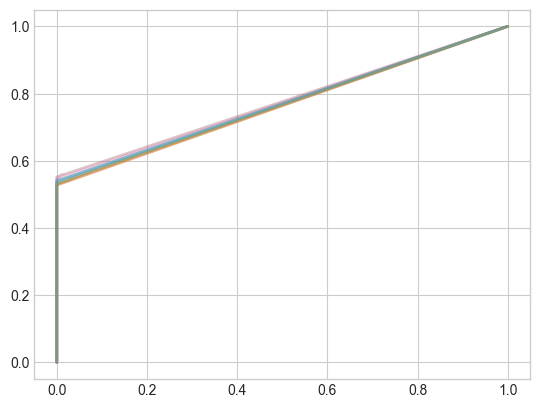

In [43]:
import numpy as np
# plot 

# Precision-recall curve with shaded area for std
# Resize one of the arrays to match the shape of the other array
precision_list = [np.resize(precision_list[i], recall_list[i].shape) for i in range(len(precision_list))]

# ROC curve with shaded area for std
plt.figure()
for i in range(len(fpr_list)):
    plt.plot(fpr_list[i], tpr_list[i], lw=2, alpha=0.3)
plt.plot(np.mean(fpr_list, axis=0), np.mean(tpr_list, axis=0), color='b', lw=2)
plt.fill_between(np.mean(fpr_list, axis=0), 
                 np.mean(tpr_list, axis=0) - np.std(tpr_list, axis=0),
                 np.mean(tpr_list, axis=0) + np.std(tpr_list, axis=0),
                 alpha=0.2, color='b')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

# AUC scores
print(f'AUC scores: {auc_scores}')
# average AUC score
print(f'Average AUC score: {np.mean(auc_scores)}')

# Feature importance
feature_importance = np.mean(feature_importance, axis=0)
feature_importance = pd.DataFrame(feature_importance, columns=X_train.columns)
feature_importance = feature_importance.mean(axis=0).sort_values(ascending=False)
# plot 
plt.figure()
feature_importance.plot(kind='bar')
plt.title('Feature importance')
plt.show()


# LGBM


In [35]:
X_train

,DISBURSED_AMOUNT,ASSET_COST,weekday_OF_DISBURSAL_pca_124,weekday_OF_BIRTH_pca_149,weekday_OF_DISBURSAL_pca_174,month_OF_DISBURSAL_pca_1,weekday_OF_DISBURSAL_pca_49,weekday_OF_BIRTH_pca_199,month_OF_BIRTH_pca_149,EMPLOYMENT_TYPE_pca_99,...,PERFORM_CNS_SCORE_DESCRIPTION_pca_21,PERFORM_CNS_SCORE_DESCRIPTION_pca_55,PERFORM_CNS_SCORE_DESCRIPTION_pca_173,PERFORM_CNS_SCORE_DESCRIPTION_pca_123,PERFORM_CNS_SCORE_DESCRIPTION_pca_57,PERFORM_CNS_SCORE_DESCRIPTION_pca_78,weekday_OF_DISBURSAL_pca_150,PERFORM_CNS_SCORE_DESCRIPTION_pca_127,month_OF_BIRTH_pca_79,month_OF_BIRTH_pca_188
UNIQUEID,,,,,,,,,,,,,,,,,,,,,
420825,50578,58400,-8.500145e-16,1.457168e-16,-8.118506e-16,0.120249,2.220446e-16,-3.330669e-16,-1.887379e-15,2.480655e-15,...,7.355228e-16,1.609823e-15,-1.163132e-15,-1.776357e-15,-2.331468e-15,-2.775558e-16,-3.261280e-16,4.440892e-16,-2.220446e-16,-5.828671e-16
537409,47145,65550,2.046974e-16,-3.053113e-16,9.436896e-16,10.101516,4.440892e-16,9.714451e-16,1.124101e-15,-1.020017e-15,...,-2.664535e-15,7.216450e-16,1.693090e-15,2.942091e-15,2.220446e-15,-5.551115e-17,4.579670e-16,-6.383782e-16,2.775558e-16,-7.979728e-17
417566,53278,61360,2.046974e-16,1.242062e-15,9.436896e-16,0.120249,4.440892e-16,-2.498002e-16,8.321252e-16,-1.020017e-15,...,7.355228e-16,1.609823e-15,-1.163132e-15,-1.776357e-15,-2.331468e-15,-2.775558e-16,4.579670e-16,4.440892e-16,1.137979e-15,1.484923e-15
624493,57513,66113,-8.500145e-16,-4.024558e-16,-8.118506e-16,-6.941942,2.220446e-16,7.494005e-16,-5.967449e-16,-1.020017e-15,...,-3.108624e-15,-7.494005e-16,2.914335e-15,1.609823e-15,2.831069e-15,1.387779e-15,-3.261280e-16,2.220446e-16,-4.512992e-16,-1.179612e-15
539055,52378,60300,2.046974e-16,8.534840e-16,9.436896e-16,10.101516,4.440892e-16,-6.106227e-16,-5.967449e-16,-1.020017e-15,...,7.355228e-16,1.609823e-15,-1.163132e-15,-1.776357e-15,-2.331468e-15,-2.775558e-16,4.579670e-16,4.440892e-16,-4.512992e-16,-1.179612e-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
626432,63213,105405,-8.500145e-16,9.436896e-16,-8.118506e-16,-6.941942,2.220446e-16,-8.014422e-16,8.321252e-16,2.480655e-15,...,-1.290634e-15,-8.326673e-16,1.700029e-15,2.470246e-15,2.664535e-15,4.996004e-16,-3.261280e-16,5.967449e-16,1.137979e-15,1.484923e-15
606141,73651,100600,2.331468e-15,9.436896e-16,9.436896e-16,-6.941942,2.498002e-16,-8.014422e-16,-5.967449e-16,-1.020017e-15,...,-2.581269e-15,-1.221245e-15,2.012279e-16,9.436896e-16,2.109424e-15,6.106227e-16,5.828671e-16,-8.083811e-16,-4.512992e-16,-1.179612e-15
613658,33484,71212,2.046974e-16,-2.137179e-15,9.436896e-16,-6.941942,4.440892e-16,1.026956e-15,1.269818e-15,2.480655e-15,...,7.355228e-16,1.609823e-15,-1.163132e-15,-1.776357e-15,-2.331468e-15,-2.775558e-16,4.579670e-16,4.440892e-16,8.881784e-16,-4.163336e-16


In [36]:
import lightgbm as lgb
from sklearn.model_selection import KFold

# Define the parameters for LightGBM
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'cross_entropy',
    'metric': 'average_precision,auc,recall,precision,f1',
    'learning_rate': 0.05,
    'num_leaves': 200,
    'num_iterations': 450,
    'verbose': 0,
    'colsample_bytree': 0.8,
    'subsample': 0.9,
    'max_depth': 18,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'min_split_gain': 0.01,
    'min_child_weight': 1,
    # 'feature_name': 'auto',
    # 'categorical_feature': 'auto'
}

# Create the LightGBM dataset
lgb_train = lgb.Dataset(data=X_train, label=y_train)


In [37]:
lgb.__version__

'3.2.1'

In [38]:
import sklearn
# Perform 10-fold cross-validation
kf_stratified = sklearn.model_selection.StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_results = lgb.cv(params= params,train_set= lgb_train, folds=kf_stratified, num_boost_round=10, early_stopping_rounds=10, verbose_eval=50, seed=42, metrics=['average_precision','auc','recall','precision','f1'], stratified=True, shuffle=True, return_cvbooster=True)


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.120102 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.126785 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.127544 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.106118 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.129842 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.108948 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM]

In [39]:
print(round(cv_results['average_precision-mean'][-1],4), "+-", round(cv_results['average_precision-stdv'][-1], 4))
print()
print(round(cv_results['auc-mean'][-1], 4), "+-", round(cv_results['auc-stdv'][-1], 4))
# precision recall f1
# print(round(cv_results['precision-mean'][-1], 4), "+-", cv_results['precision-stdv'][-1])

0.2927 +- 0.0051

0.6164 +- 0.0033


In [40]:
print("vehicle loan llama pca 200 - 20")

vehicle loan llama pca 200 - 20


In [51]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc
# Initialize arrays to store the evaluation metrics and feature importance
precision = []
recall = []
fpr = []
tpr = []
auc_scores = []
feature_importance = []

# go through boosters and evaluate on the test set
for (booster, (train,test))  in zip(cv_results['cvbooster'].boosters, kf_stratified.split(X_train, y_train)):
    # Make predictions on the testing set
    y_prob = booster.predict(X_train.iloc[test])
    # y_prob = booster.predict_proba(X_test)[:, 1]
    # precision precision, recall, and F1-score
    precision_fold, recall_fold, _ = precision_recall_curve(y_train.iloc[test], y_prob)
    precision.append(precision_fold)
    recall.append(recall_fold)

    # Calculate TPR, FPR, and AUC
    fpr_fold, tpr_fold, _ = roc_curve(y_train.iloc[test], y_prob)
    fpr.append(fpr_fold)
    tpr.append(tpr_fold)
    auc_scores.append(auc(fpr_fold, tpr_fold))

    # Calculate feature importance
    feature_importance_fold = booster.feature_importance()  # Replace with your feature importance calculation
    feature_importance.append(feature_importance_fold)


## PRC and ROC curves with std as shaded areas

In [64]:
import seaborn as sns
# theme
sns.set_style('darkgrid')

In [65]:

def pader(fpr, val):
    l = [len(i) for i in fpr]
    max_l = max(l)
    for i in range(len(fpr)):
        # pad with trailing 1s to make sure we reach 100% recall
        # i is a np array
        for j in range(len(fpr[i]), max_l):
            fpr[i] = np.append(fpr[i], val)
    return fpr

fpr = pader(fpr, 1)
precision = pader(precision, 1)
recall = pader(recall, 0)
tpr = pader(tpr, 1)

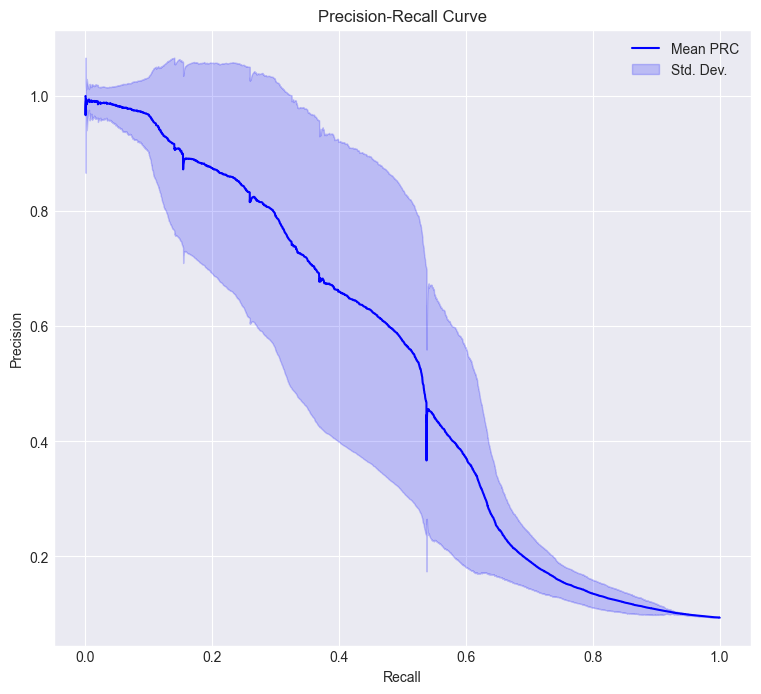

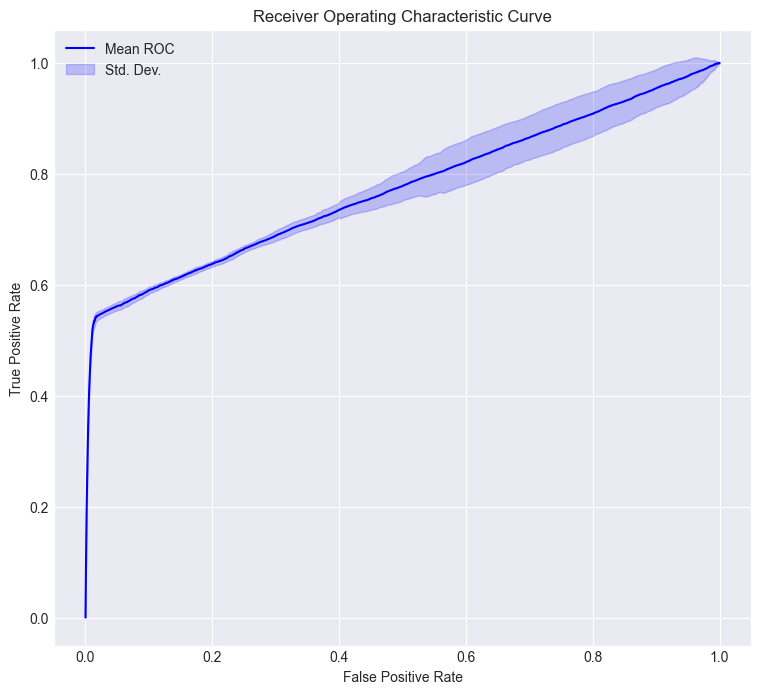

In [66]:

# Calculate the mean and standard deviation of the evaluation metrics
precision_mean = np.mean(precision, axis=0)
precision_std = np.std(precision, axis=0)
recall_mean = np.mean(recall, axis=0)
recall_std = np.std(recall, axis=0)
fpr_mean = np.mean(fpr, axis=0)
fpr_std = np.std(fpr, axis=0)
tpr_mean = np.mean(tpr, axis=0)
tpr_std = np.std(tpr, axis=0)
auc_mean = np.mean(auc_scores)
auc_std = np.std(auc_scores)

# Plot the PRC curve with shaded area
fig , ax = plt.subplots(figsize=(9, 8))
ax.plot(recall_mean, precision_mean, color='b', label='Mean PRC')
ax.fill_between(recall_mean, precision_mean - precision_std, precision_mean + precision_std, color='b', alpha=0.2 , label='Std. Dev.')
# add shaded area in the legend
# ax.plot([], [], 'b', alpha=0.2, label='Std. Dev.')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision-Recall Curve')
ax.legend()
plt.show()

# Plot the ROC curve with shaded area
plt.figure(figsize=(9, 8))
plt.plot(fpr_mean, tpr_mean, color='b', label='Mean ROC')
plt.fill_between(fpr_mean, tpr_mean - tpr_std, tpr_mean + tpr_std, color='b', alpha=0.2,  label='Std. Dev.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend()
plt.show()


## Plot the feature importance with error bars

In [67]:
feature_importance_mean = np.mean(feature_importance, axis=0)
feature_importance_std = np.std(feature_importance, axis=0)
# pair feature importance values with feature names
feature_importance = zip(X_train.columns, feature_importance_mean, feature_importance_std)
# just select the ones that are bigger than 0.1
feature_importance = [x for x in feature_importance if x[1] > 0]


In [68]:
# feature_importance = [x for x in feature_importance if x[1] > 0]


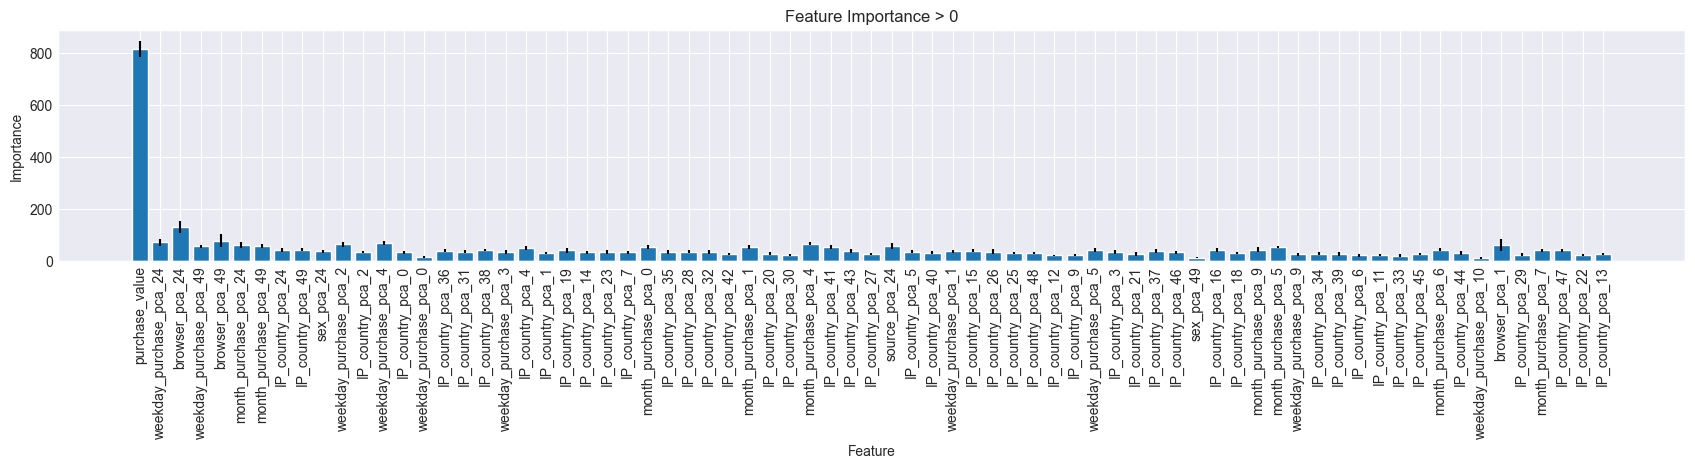

In [69]:

plt.figure(figsize=(21,3))
#  extract feature names and importance values
feature_names = [x[0] for x in feature_importance]
importance_values = [x[1] for x in feature_importance]
# create error bars using standard deviation
error_values = [x[2] for x in feature_importance]
# plot the feature importance
plt.bar(feature_names, importance_values, yerr=error_values)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance > 0')
plt.xticks(rotation=90)
plt.show()

In [25]:

# Save the values of feature importance 
# feature_importance_mean = np.mean(feature_importance, axis=0)
# feature_importance_std = np.std(feature_importance, axis=0)
feature_importance_df = pd.DataFrame({'feature': X_train.columns, 'importance': feature_importance_mean, 'std': feature_importance_std})
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)    
feature_importance_df.to_csv('./plots/fraudecom_lgbm_w2v_feature_importance.csv', index=False)



In [16]:
cv_results['cvbooster'].boosters[0]

In [14]:
cv_results['cvbooster'].best_iteration

136

In [70]:
print(round(cv_results['average_precision-mean'][-1],4), "+-", round(cv_results['average_precision-stdv'][-1], 4))
print()
print(round(cv_results['auc-mean'][-1], 4), "+-", round(cv_results['auc-stdv'][-1], 4))
# precision recall f1
# print(round(cv_results['precision-mean'][-1], 4), "+-", cv_results['precision-stdv'][-1])

0.5681 +- 0.0066

0.773 +- 0.004


In [19]:
x_train, x_val, y_train_, y_val = train_test_split(X_train[:], y_train[:], test_size=0.2, random_state=18)
lgb_train = lgb.Dataset(data=x_train, label=y_train_, feature_name= 'auto', # that's actually the default
            categorical_feature= 'auto') # that's actually the default)
lgb_eval = lgb.Dataset(data=x_val, label=y_val)

In [20]:
params = {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc,average_precision',
          'learning_rate': 0.05, 'num_leaves': 200, 'num_iteration': 450, 'verbose': 0 ,
          'colsample_bytree':.8, 'subsample':.9, 'max_depth':18, 'reg_alpha':.1, 'reg_lambda':.1,
          'min_split_gain':.01, 'min_child_weight':1, 'feature_name': 'auto', # that's actually the default
            'categorical_feature': 'auto'} # that's actually the default}
model = lgb.train(params, lgb_train, valid_sets=lgb_eval, early_stopping_rounds=60, verbose_eval=60)

[LightGBM] [Warning] Unknown parameter: feature_name
[LightGBM] [Warning] Unknown parameter: feature_name
[LightGBM] [Warning] categorical_feature is set=auto, categorical_column=2,3,4,5,6,7,8,9,10,13,14,44,45,46,47,48,49,50,51,52,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431 will be ignored. Current value: categorical_feature=auto
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004803 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Unknown parameter: feature_name
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 60 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

Average precision-recall score: 0.6724


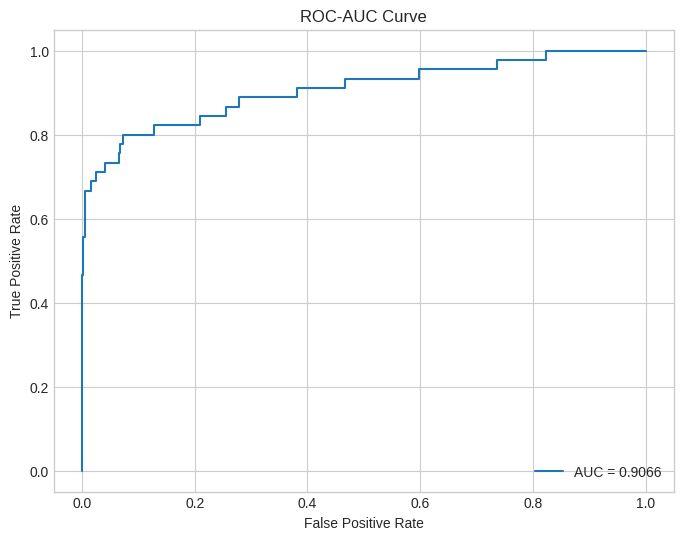

In [21]:
from sklearn.metrics import roc_curve, auc, average_precision_score

# Predict on the validation set
y_pred = model.predict(x_val)

# Calculate AUC
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
roc_auc = auc(fpr, tpr)

# Calculate average precision score
average_precision = average_precision_score(y_val, y_pred)
print('Average precision-recall score: {0:0.4f}'.format(average_precision))

# Plot AUC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
plt.title('ROC-AUC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

## Recall & Precision per thresh and by $

In [43]:
import numpy as np


# Define the thresholds
thresholds = np.linspace(0, 1, num=10)

# Initialize lists to store recall, precision, and sum of amount for each threshold
recall_list = []
precision_list = []
amount_sum_list = []

# Iterate over each threshold
for threshold in thresholds:
    # Apply the threshold to the predicted probabilities
    y_pred_threshold = (y_pred >= threshold).astype(int)
    
    # Calculate recall and precision
    recall = np.sum((y_pred_threshold == 1) & (y_val == 1)) / np.sum(y_val == 1)
    precision = np.sum((y_pred_threshold == 1) & (y_val == 1)) / np.sum(y_pred_threshold == 1)
    
    # Calculate the sum of amount
    amount_sum = np.sum(x_val[y_pred_threshold == 1]['TransactionAmt'])
    
    # Append the values to the lists
    recall_list.append(recall)
    precision_list.append(precision)
    amount_sum_list.append(amount_sum)

# Print the results
for i in range(len(thresholds)):
    print(f"Threshold: {thresholds[i]:.2f}, Recall: {recall_list[i]:.4f}, Precision: {precision_list[i]:.4f}, Sum of Amount: {amount_sum_list[i]:.2f}")


Threshold: 0.00, Recall: 1.0000, Precision: 0.0225, Sum of Amount: inf
Threshold: 0.11, Recall: 0.6667, Precision: 0.5556, Sum of Amount: 8088.00
Threshold: 0.22, Recall: 0.6444, Precision: 0.7250, Sum of Amount: 5252.00
Threshold: 0.33, Recall: 0.5556, Precision: 0.8333, Sum of Amount: 4026.00
Threshold: 0.44, Recall: 0.4667, Precision: 0.9130, Sum of Amount: 3286.00
Threshold: 0.56, Recall: 0.3556, Precision: 0.9412, Sum of Amount: 1913.00
Threshold: 0.67, Recall: 0.2889, Precision: 1.0000, Sum of Amount: 1510.00
Threshold: 0.78, Recall: 0.1778, Precision: 1.0000, Sum of Amount: 1164.00
Threshold: 0.89, Recall: 0.0889, Precision: 1.0000, Sum of Amount: 1001.00
Threshold: 1.00, Recall: 0.0000, Precision: nan, Sum of Amount: 0.00


In [46]:
# Calculate the total number of fraud instances
total_fraud = np.sum(y_val == 1)

# Calculate the number of true positive instances
true_positive = np.sum((y_pred_threshold == 1) & (y_val == 1))

# Calculate the recall out of total fraud instances
recall_out_of_total_fraud = true_positive / total_fraud

print(f"Recall out of total fraud instances: {recall_out_of_total_fraud:.4f}")


Recall out of total fraud instances: 0.0000


## Feature importance colored by the dtype

In [17]:
feature_importance = model.feature_importance(importance_type='gain')
feature_names = model.feature_name()

# Create a dictionary to store the feature importance and dtypes
feature_importance_dict = dict(zip(feature_names, zip(feature_importance, X_train.dtypes)))

# Sort the feature importance dictionary by value in descending order
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1][0], reverse=True)

# Print the feature importance and dtypes
for feature, (importance, dtype) in sorted_feature_importance:
    print(f'{feature}: {importance} (dtype: {dtype})')


# # Create a dictionary to store the feature importance
# feature_importance_dict = dict(zip(feature_names, feature_importance))

# # Sort the feature importance dictionary by value in descending order
# sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# # Print the feature importance
# for feature, importance in sorted_feature_importance:
#     print(f'{feature}: {importance}')


NameError: name 'model' is not defined

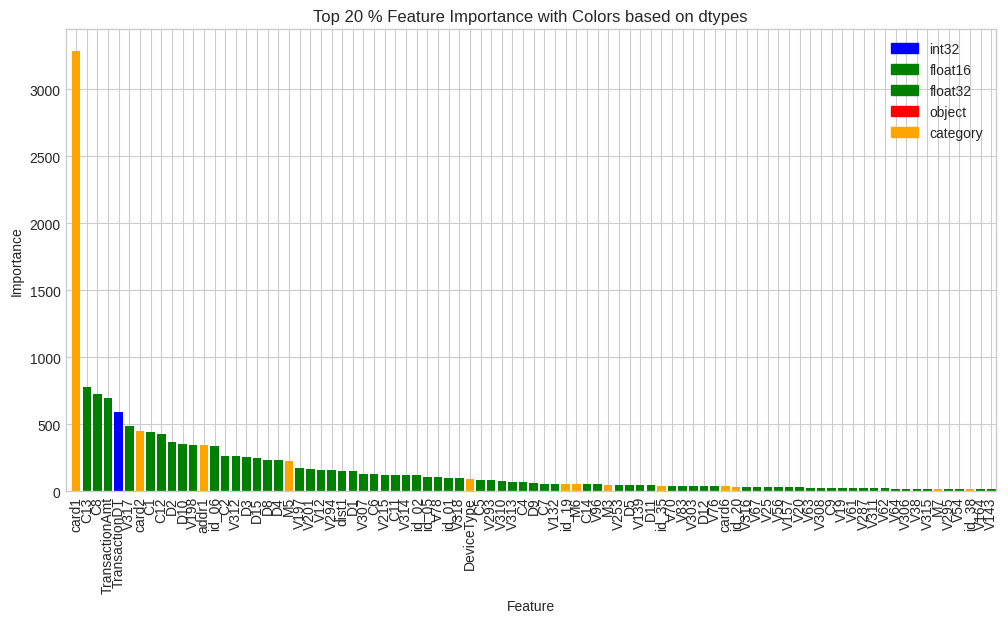

In [23]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Get the feature names and importances from the sorted feature importance
feature_names = [feature for feature, (_, dtype) in sorted_feature_importance]
importances = [importance for _, (importance, _) in sorted_feature_importance]
dtypes = [dtype for _, (_, dtype) in sorted_feature_importance]

# Create a color map based on dtypes
color_map = {'int32': 'blue', 'float16': 'green', 'float32': 'green', 'object': 'red', 'category': 'orange'}
colors = [color_map[dtype.name] for dtype in dtypes]

# Create the bar plot
plt.figure(figsize=(12, 6))
plt.bar(feature_names, importances, color=colors)
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
# limit the ylim to 0-1000
# plt.ylim(0, 1000)
plt.xlim(-1, len(feature_names)/5) 
# legend
handles = [mpatches.Patch(color=color, label=dtype) for dtype, color in color_map.items()]
plt.legend(handles=handles)
plt.title('Top 20 % Feature Importance with Colors based on dtypes')
plt.show()


## SHAP importance 

In [22]:
import shap
shap.initjs()
model = cv_results['cvbooster'].boosters[-1]


In [23]:

shap_values = shap.TreeExplainer(model).shap_values(X_one_hot_train.iloc[test]) 

In [32]:
shap_values.shape

(23315, 88)

In [25]:
import matplotlib.pyplot as plt

# Get the SHAP values for class 0 and class 1
shap_values_class0 = shap_values[0]
shap_values_class1 = shap_values[1]

# Create the summary plot for class 0
plt.figure(figsize=(12, 6))
shap.summary_plot(shap_values_class0, X_one_hot_train.iloc[test], show=False)
plt.title('SHAP Values - Class 0')
plt.tight_layout()

# Create the summary plot for class 1
plt.figure(figsize=(12, 6))
shap.summary_plot(shap_values_class1, X_one_hot_train.iloc[test], show=False)
plt.title('SHAP Values - Class 1')
plt.tight_layout()

# Show the plots
plt.show()


AssertionError: Summary plots need a matrix of shap_values, not a vector.

<Figure size 1200x600 with 0 Axes>

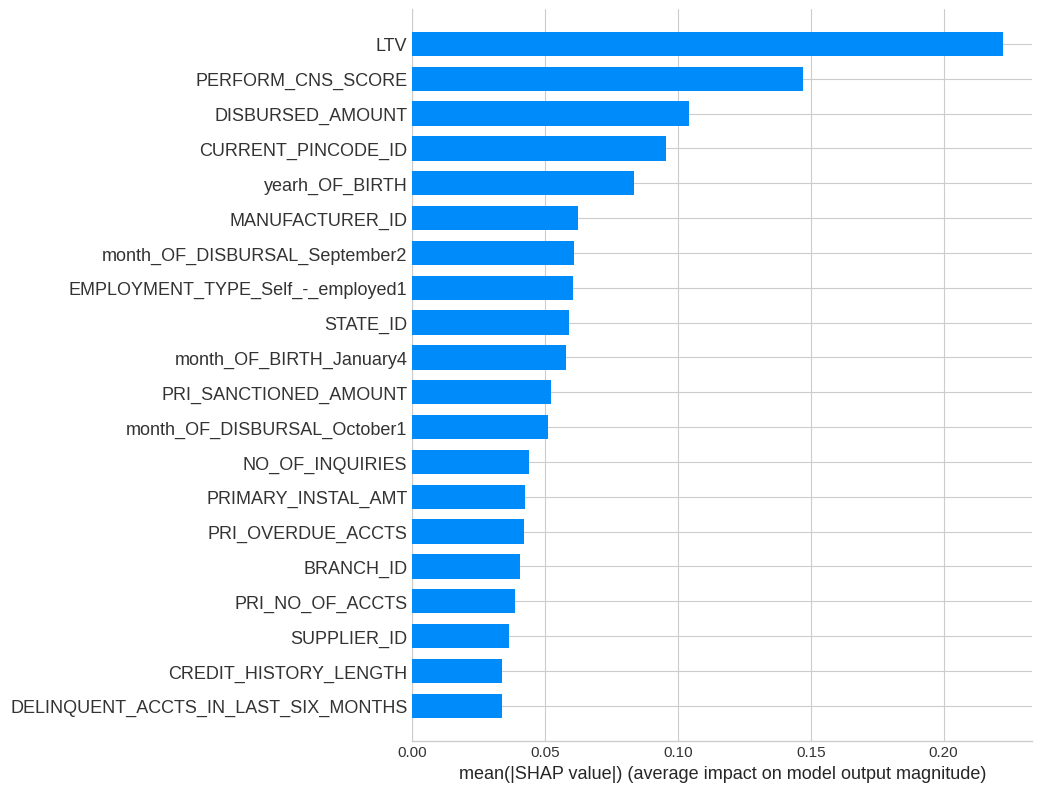

In [33]:
shap.summary_plot(shap_values, X_one_hot_train.iloc[test] , plot_type="bar", max_display=20, show=False, 
                  # add the type of the feature to the label
                  )



## Sum of Feature Importance by DataType Normalized by Feature Count

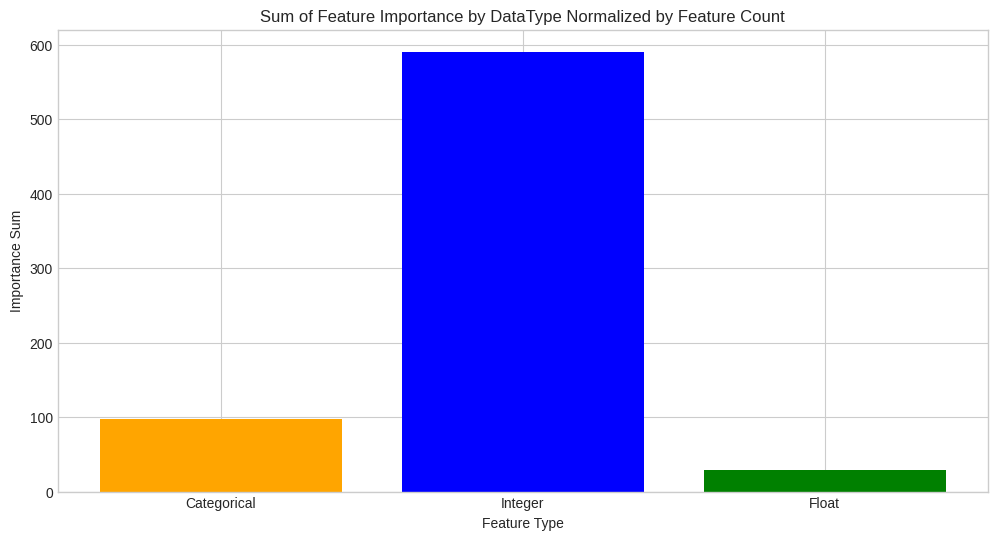

In [ ]:
import matplotlib.pyplot as plt

# Initialize the sums
cat_sum = 0
int_sum = 0
float_sum = 0

cat_count = 0
int_count = 0
float_count = 0

# Get the feature names and importances from the sorted feature importance
feature_names = [feature for feature, (_, dtype) in sorted_feature_importance]
importances = [importance for _, (importance, _) in sorted_feature_importance]
dtypes = [dtype for _, (_, dtype) in sorted_feature_importance]

# Iterate over the features and their importances
for feature, importance, dtype in zip(feature_names, importances, dtypes):
    if dtype.name.startswith('int'):
        int_sum += importance
        int_count += 1
    elif dtype.name.startswith('float'):
        float_sum += importance
        float_count += 1
    else:
        cat_sum += importance
        cat_count += 1

cat_norm = cat_sum / cat_count
int_norm = int_sum / int_count
float_norm = float_sum / float_count


# Create the bar plot
plt.figure(figsize=(12, 6))
plt.bar(['Categorical', 'Integer', 'Float'], [cat_norm, int_norm, float_norm],  color=['orange', 'blue', 'green'])
plt.xlabel('Feature Type')
plt.ylabel('Importance Sum')
plt.title('Sum of Feature Importance by DataType Normalized by Feature Count')
plt.show()


In [ ]:
from sklearn.metrics import roc_curve, auc

# Predict on the validation set
y_pred = model.predict(x_val)

# Calculate AUC
fpr_LE, tpr_LE, thresholds = roc_curve(y_val, y_pred)
roc_auc_LE = auc(fpr_LE, tpr_LE)

import pickle

# Create a dictionary to store the data
roc_data = {
    'fpr': fpr_LE,
    'tpr': tpr_LE,
    'roc_auc': roc_auc_LE
}

# Save the data to a file
with open('roc_data.pkl', 'wb') as file:
    pickle.dump(roc_data, file)


# Load the data from the file
with open('roc_data.pkl', 'rb') as file:
    roc_data = pickle.load(file)

# Access the loaded data
fpr = roc_data['fpr']
tpr = roc_data['tpr']
roc_auc = roc_data['roc_auc']
